<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/Time%20Series/energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with Engergy Consumption data
**Source**: [Time Series Forecasting with XGBoost](https://youtu.be/vV12dGe_Fho?si=vYrGFNEIDf2xxY0k) by Rob Mulla.

In [15]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # viz
import seaborn as sns # viz
import os # operating system
import xgboost as xgb # model

# evaluation
from sklearn.metrics import mean_squared_error as mse

# style
sns.set_style('whitegrid', {'grid.color': "lightgray"})

# _1. Get the data
**Source**: Rob Mulla. 2018. [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). Kaggle Datasets.

From the dataset, I'll use `PJME_hourly.csv`.
> ⚠ Since I work on colab, I'll use a version of the data file from my GitHub repo because I don't want to bother myself with the Kaggle API drama.

In [16]:
# Read the data with pandas
URL = 'https://github.com/mohamedyosef101/101_learning_area/raw/area/Time%20Series/data/PJME_hourly.csv'
data = pd.read_csv(URL)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


From this little info, we get the we have 145k observations. Also, there is no missing values.

# _2. Data Exploration

In [17]:
# Rename the data
data = data.rename(columns={'Datetime': 'dt', 'PJME_MW': 'target'})
data.tail(3)

,dt,target
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [18]:
# set the index as datetime
data = data.set_index('dt')
data.index = pd.to_datetime(data.index)

# make sure that the data is sorted
data = data.sort_index(ascending=True)

data.head(3)

,target
dt,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0


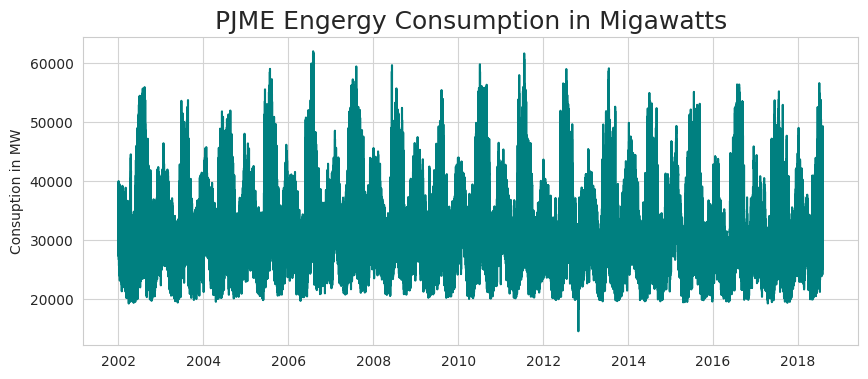

In [19]:
# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(data['target'], color='teal')
plt.title("PJME Engergy Consumption in Migawatts", fontsize=18)
plt.ylabel("Consuption in MW")
plt.show()

From the plot, our data range from 2002 to 2018

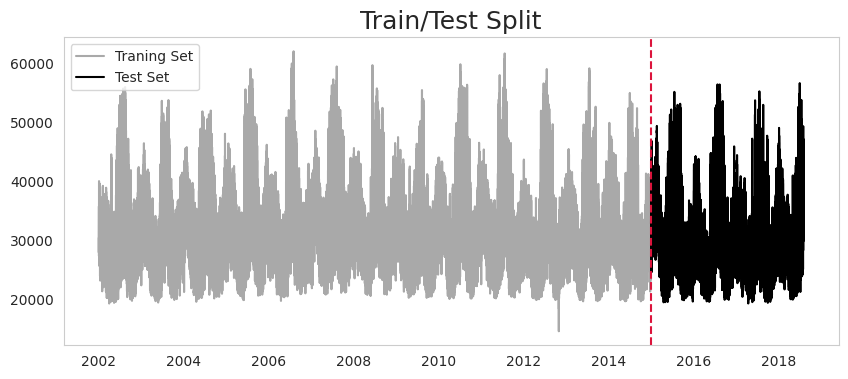

In [20]:
# train/test split by years
train = data.loc[data.index < '2015-01-01'] # everything before 2015
test = data.loc[data.index >= '2015-01-01'] # 2015 and after
split_date = pd.to_datetime('2015-01-01')

# plot the split
plt.figure(figsize=(10, 4))
plt.plot(train.target, label="Traning Set", color='darkgray')
plt.plot(test.target, label="Test Set", color='black')
plt.axvline(split_date, color='crimson', ls='--')
plt.legend(loc='best')
plt.title("Train/Test Split", fontsize=18)
plt.grid(False)
plt.show()

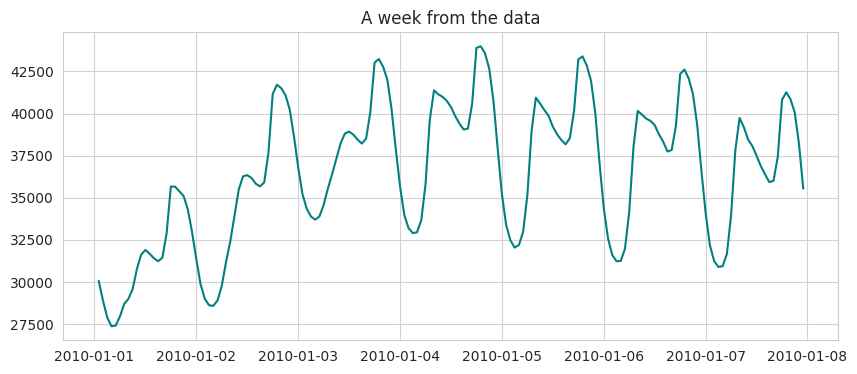

In [21]:
# Explore a week of the data
week = data.loc[(data.index > '2010-01-01') & (data.index < '2010-01-08')]
plt.figure(figsize=(10, 4))
plt.plot(week, color='teal')
plt.title("A week from the data")
plt.show()

# _3. Feature Engineering


In [22]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [23]:
data = create_features(data)

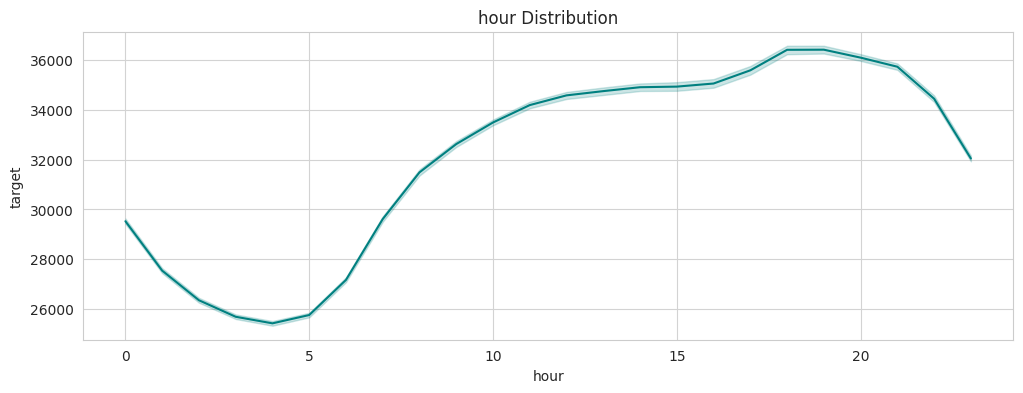

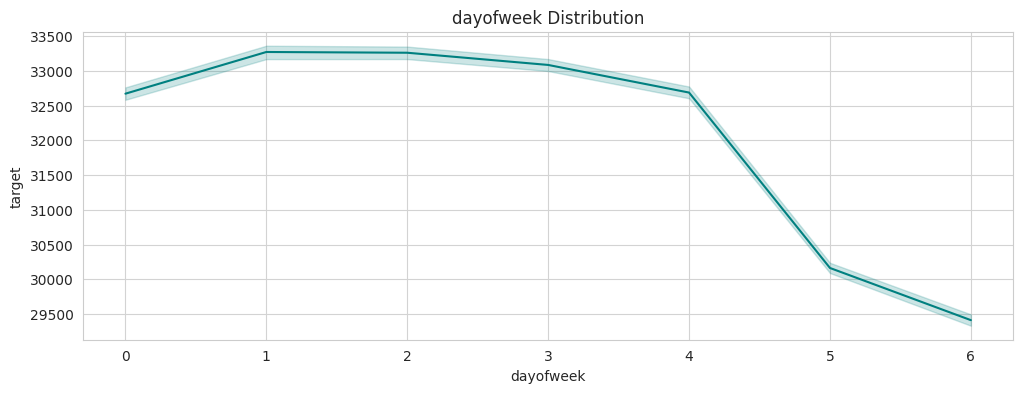

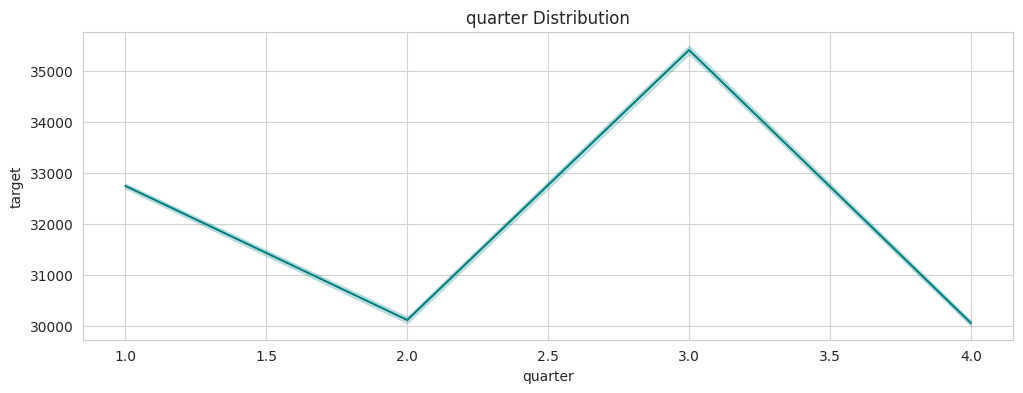

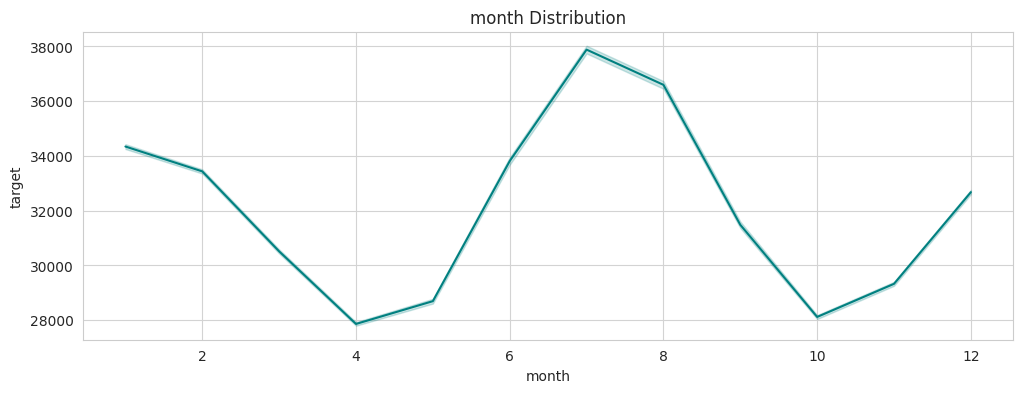

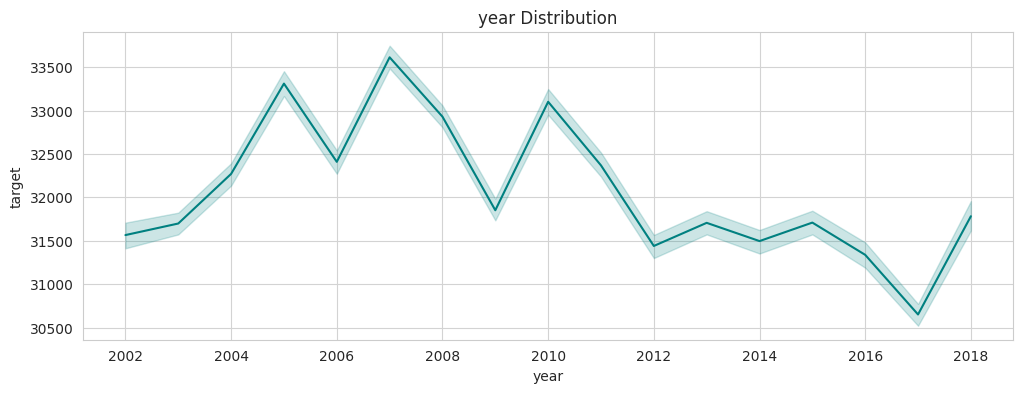

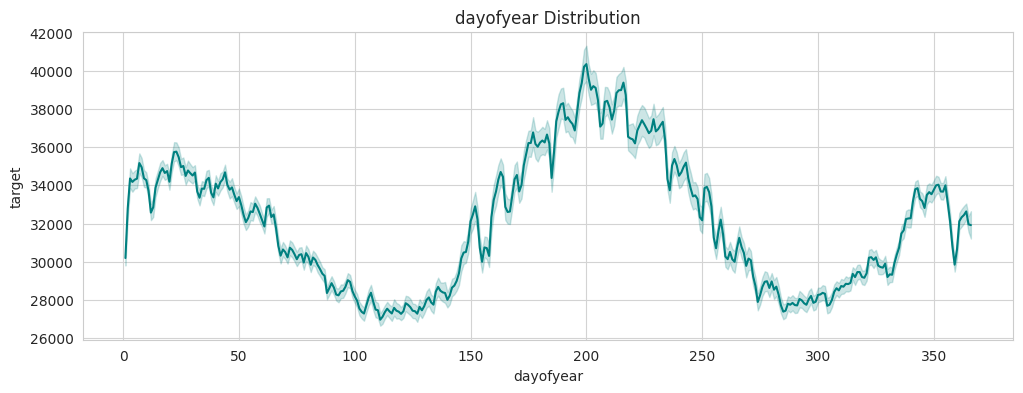

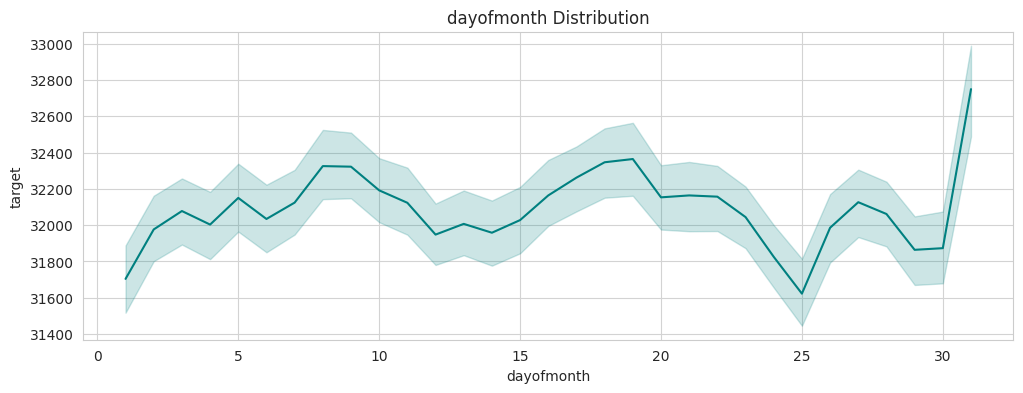

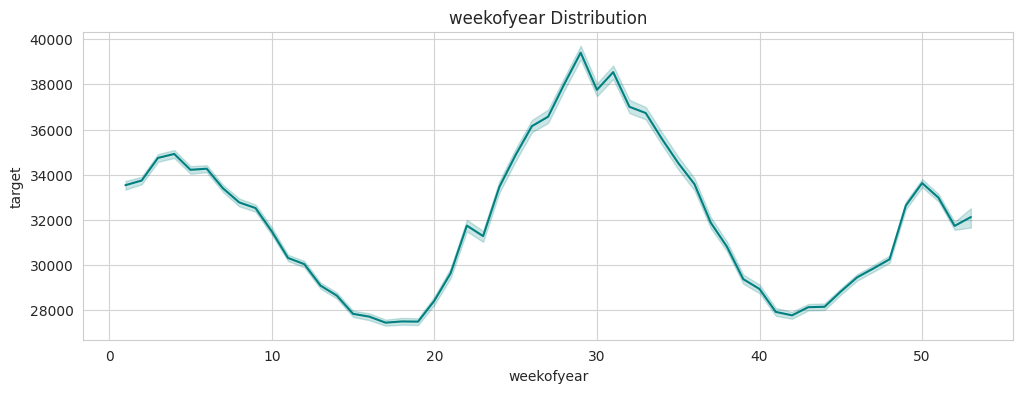

In [31]:
# Get the distribution of every feature vs. target
features = data.drop('target', axis=1)
cols=features.columns
for col in cols:
  plt.figure(figsize=(12, 4))
  sns.lineplot(data, x=col, y='target', color="teal")
  plt.title(f"{col} Distribution")
  plt.show()

# _4. Modeling

In [33]:
train = create_features(train)
test = create_features(test)

target = 'target'

X_train = train[cols]
y_train = train[target]

X_test = test[cols]
y_test = test[target]

In [34]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35068	validation_1-rmse:11747.06148
[200]	validation_0-rmse:5835.20181	validation_1-rmse:5360.72049
[300]	validation_0-rmse:3923.74110	validation_1-rmse:4005.82843
[400]	validation_0-rmse:3448.38660	validation_1-rmse:3852.29791
[500]	validation_0-rmse:3288.20557	validation_1-rmse:3814.18080
[600]	validation_0-rmse:3203.52037	validation_1-rmse:3784.57136
[700]	validation_0-rmse:3147.35907	validation_1-rmse:3769.18571
[800]	validation_0-rmse:3108.87801	validation_1-rmse:3752.68218
[900]	validation_0-rmse:3076.71939	validation_1-rmse:3744.18258
[999]	validation_0-rmse:3048.28199	validation_1-rmse:3735.60177


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# _5. Feature Importance

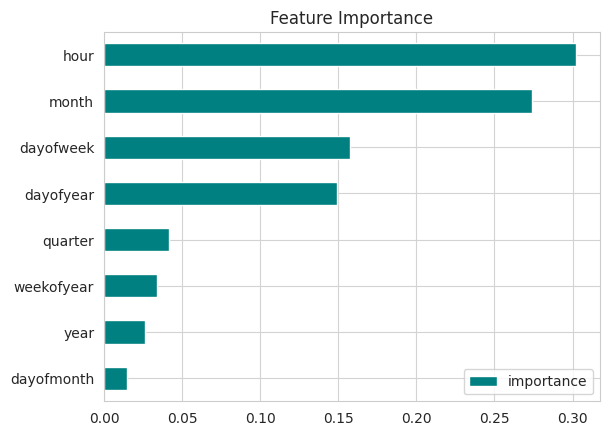

In [36]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh',
                                  title="Feature Importance",
                                  color='teal')
plt.show()

# _6. Forecast on Test

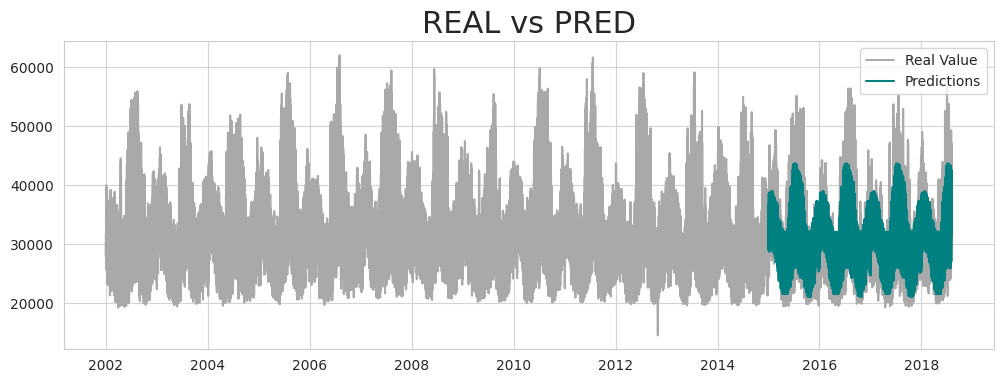

In [37]:
test['prediction'] = reg.predict(X_test)

data = data.merge(test[['prediction']], how='left',
                  left_index=True, right_index=True)
plt.figure(figsize=(12, 4))
plt.plot(data.target, color='darkgray', label='Real Value')
plt.plot(data.prediction, color='teal', label='Predictions')
plt.title("REAL vs PRED", fontsize=22)
plt.legend(loc='best')
plt.show()

# _7. Score (RMSE)

In [38]:
score = np.sqrt(mse(test.target, test.prediction))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3735.60
